# Treatability scores

## Plain English summary

This notebook shows how to create a "treatability score" for a patient based on some of their characteristics. 

The method assumes that any XGBoost prediction or SHAP explainer models cannot be used directly. For example, we might not want to include a specific stroke team as required by those models, or we might be using a framework that makes it difficult or slow to access the models. 

Instead, we use the SHAP explainer to find average SHAP values for each possible value of each patient feature. When there are a small number of possible values, for example pre-stroke mRS from 0 to 5, a separate average SHAP is found for each. When there are a much larger number of possible values, for example onset-to-arrival time in minutes, the data is first grouped into smaller ranges of values and then the mean SHAP found across each range. This average SHAP value is the same for multiple patients with the same feature value and so this method gives more consistent results than from calculating new SHAP values from the explainer. 

The treatability scores are calculated by gathering each patient's SHAP value in each category from the average values, and then summing these multiple SHAP values. 

This notebook also shows an example of using the treatability scores when selecting a subset of patients to be treated. The patients with higher scores are more likely to be selected from the list, but it is still possible to select patients with lower scores.

## Sources

Data processing is copied from here: https://github.com/stroke-modelling/stroke-utilities/blob/main/docs/01_create_predictor_shap_and_benchmark_rankings.ipynb

Box plot creation is copied from here: https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03a_xgb_all_data_shap_values_vs_feature_values.ipynb

## Notebook setup:

In [21]:
import pandas as pd
import numpy as np
from dataclasses import dataclass

import matplotlib.pyplot as plt

import stroke_utilities.process_data as process_data

# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import shap

## Set up paths and filenames

In [22]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    uncert_read_path: str = './uncertainty/'
    data_read_path: str = './stroke_utilities/data/'
    output_folder = './stroke_utilities/output/'

paths = Paths()

## Load data

Import the data from file:

In [23]:
# Load SHAP summary dataframe:
df_shap_std = pd.read_csv(paths.uncert_read_path + 'shap_std.csv')

In [25]:
df_shap_std

,feature,feature_value,mean_shap,std_shap
0,stroke_severity,0,-2.759728,0.476846
1,stroke_severity,1,-2.410901,0.420371
2,stroke_severity,2,-1.625403,0.301874
3,stroke_severity,3,-0.987334,0.250921
4,stroke_severity,4,-0.256834,0.170534
...,...,...,...,...
316,team_117,1,-0.688748,0.286864
317,team_118,0,-0.005982,0.002915
318,team_118,1,0.667060,0.340155
319,team_119,0,0.000004,0.000719


Load test data set and process it as though ready for a SHAP explainer.

In [35]:
# Load data
test = pd.read_csv(paths.data_read_path + 'cohort_10000_test.csv')
test['stroke_team_id'] = test['stroke_team_id'].astype('category')

# One-hot-encode the teams:
X_test, y_test = process_data.split_X_and_y(test, 'thrombolysis')
X_test = process_data.one_hot_encode_column(
    X_test, 'stroke_team_id', prefix='team')

X_test = X_test.drop('year', axis=1)

## Extract data from the SHAP summary dataframe

The following function picks out the mean and std of the SHAP values for a given feature and its value.

In [33]:
def get_std_from_df(df, col, value):
    """
    
    # What are +/- values for each of the features?
    """
    # Filter this feature only:
    df_col = df[df['feature'] == col]
    try:
        df_col['feature_value'] = df_col['feature_value'].astype(float)
    except ValueError:
        # Can't convert these values to float.
        pass
    # Find where the feature value matches input:
    if value in list(df_col['feature_value'].values):
        df_row = df_col[df_col['feature_value'] == value]
    else:
        # The exact value doesn't exist when the feature
        # is age, onset-to-arrival time, or arrival-to-scan time.
        # Temporarily? The exact value doesn't exist for
        # anticoagulant value missing.
        if 'anticoag' in col:
            df_row = df_col[
                (df_col['feature_value'] != 0) &
                (df_col['feature_value'] != 1)
                ]
        elif 'age' in col:
            # Need nearest multiple of 5 plus 2.5,
            # so options are 37.5, 42.5, 47.5, ... 92.5.
            if value < 37.5:
                value = 37.5
            elif value > 92.5:
                value = 92.5
            else:
                # Round to the nearest 5 and then subtract 2.5.
                # This means that age 40 goes to 37.5
                # and age 41 goes to 42.5.
                value = np.ceil(value / 5.0) * 5.0 - 2.5
            df_row = df_col[df_col['feature_value'] == value]
        elif 'time' in col:
            # Categories are string "0-29", "120-149", "150+".
            categories = np.unique(df_col['feature_value'])
            category_bounds = [float(t.replace('+','-').split('-')[0])
                               for t in categories]
            category_bounds = sorted(category_bounds)
            # Find which category the value falls into:
            bin = np.digitize(value, category_bounds) - 1
            category_here = categories[bin]
            df_row = df_col[df_col['feature_value'] == category_here]
        else:
            print('error: ', col, value)

    mean_shap = df_row['mean_shap'].values[0]
    std_shap = df_row['std_shap'].values[0]
    return mean_shap, std_shap


The following cell loops over all features and their values. It finds the mean and std of the SHAP values for each feature value. Then it finds which patients this feature value applies to and saves the results in two new arrays to match the patient test data layout.

In [87]:
shap_mean_arr = np.zeros((len(X_test), len(X_test.columns)))
shap_std_arr = np.zeros((len(X_test), len(X_test.columns)))
for f, feature in enumerate(X_test.columns):
    feature_vals = sorted(set(X_test[feature]))
    for val in feature_vals:
        mean_shap, std_shap =  get_std_from_df(df_shap_std, feature, val)

        # Where are these patients in the test data?
        row_mask = (X_test[feature] == val)
        if len(row_mask[row_mask == True]) == 0:
            if 'afib' in feature:
                # row_mask before didn't properly pick out the NaN values.
                row_mask = (X_test[feature] != 0) & (X_test[feature] != 1)
            else:
                print(f'Error? {feature} {val}')
        # Update these patients' values:
        shap_mean_arr[row_mask, f] = mean_shap
        shap_std_arr[row_mask, f] = std_shap

Convert the array of mean SHAP values to a DataFrame so that column names can be included.

Calculate the "treatability score" of each patient by summing all of their mean SHAP values.

In [62]:
df_all_patient_shap_values = pd.DataFrame(
    shap_mean_arr,
    columns = X_test.columns
)

# Calculate the treatability score.
df_all_patient_shap_values['treatability_score'] = (
    df_all_patient_shap_values.sum(axis=1))


In [63]:
df_all_patient_shap_values.head(5)

,stroke_severity,prior_disability,age,infarction,onset_to_arrival_time,precise_onset_known,onset_during_sleep,arrival_to_scan_time,afib_anticoagulant,team_1,...,team_111,team_112,team_113,team_114,team_115,team_116,team_117,team_118,team_119,treatability_score
0,0.475304,0.363717,0.095047,0.341060,-0.205125,0.351339,0.038979,0.265612,-1.648980,0.002158,...,0.00136,0.000734,-0.002367,0.003596,-0.009321,-0.00595,0.002385,-0.005982,0.000004,0.203616
1,-1.625403,-0.601054,-0.455455,0.341060,-0.409409,0.351339,0.038979,0.265612,0.071971,0.002158,...,0.00136,0.000734,-0.002367,0.003596,-0.009321,-0.00595,0.002385,-0.005982,0.000004,-1.403822
2,0.844426,0.363717,0.095047,0.341060,-0.205125,0.351339,0.038979,0.265612,0.233429,0.002158,...,0.00136,0.000734,-0.002367,0.003596,-0.009321,-0.00595,-0.688748,-0.005982,0.000004,1.578817
3,0.736321,-0.026161,-0.455455,0.341060,0.197819,0.351339,0.038979,-2.061086,0.071971,0.002158,...,0.00136,0.000734,-0.002367,0.003596,-0.009321,-0.00595,0.002385,-0.005982,0.000004,-1.382666
4,0.914569,-0.601054,0.059954,-9.228256,-0.205125,0.351339,0.038979,0.265612,0.233429,0.002158,...,0.00136,0.000734,-0.002367,0.003596,-0.009321,-0.00595,0.002385,-0.005982,0.000004,-8.433247


## Compare treatability score with real-life treatment decision

The original patient data includes whether the patients received thrombolysis. We can see whether a higher treatability score means a patient is more likely to receive thrombolysis.

Create masks of whether or not patients received thrombolysis:

In [65]:
mask_thrombolysed = (y_test == 1)
mask_not_thrombolysed = (y_test != 1)

Create bins for the treatability scores:

In [66]:
# Step between bins:
step = 0.5

# Bins with this step and a range spanning all scores:
hist_bins = step * np.arange(
    df_all_patient_shap_values['treatability_score'].min() // step,
    2.0 + (df_all_patient_shap_values['treatability_score'].max() // step),
    1
    ) - (0.5 * step)
# The final  - (0.5 * step) is included so that the middle of the bins
# are multiples of step.

Bin sanity check:

In [67]:
print(hist_bins[:3])
print(min(hist_bins), max(hist_bins), len(hist_bins))
print(f'{df_all_patient_shap_values["treatability_score"].min():.3f}', 
      f'{df_all_patient_shap_values["treatability_score"].max():.3f}')

[-18.75 -18.25 -17.75]
-18.75 3.75 46
-18.006 3.586


Plot the number of patients in each score bin, split by whether they were treated:

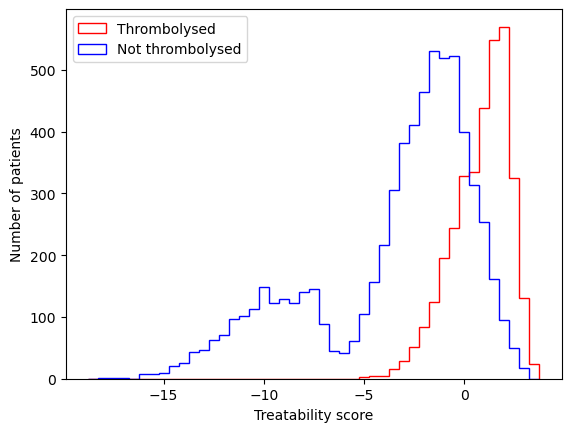

In [68]:
fig, ax = plt.subplots()

n_thrombolysed, bins, patches = ax.hist(
    df_all_patient_shap_values['treatability_score'][mask_thrombolysed], 
    bins=hist_bins, color='r', histtype='step', label='Thrombolysed')
n_not_thrombolysed, bins, patches = ax.hist(
    df_all_patient_shap_values['treatability_score'][mask_not_thrombolysed], 
    bins=hist_bins, color='b', histtype='step', label='Not thrombolysed')

ax.set_xlabel('Treatability score')
ax.set_ylabel('Number of patients')
ax.legend()
plt.show()

In this graph, the second peak below a treatability score of around minus 7 is due to the large negative SHAP value when infarction is "yes". This value is around minus 9:

In [69]:
df_shap_std[df_shap_std['feature'] == 'infarction']

,feature,feature_value,mean_shap,std_shap
61,infarction,0,-9.228256,0.749845
62,infarction,1,0.341060,0.080366


## Convert to percentage thrombolysed

The above histograms' outputs include the number of patients in each score bin. Use these to calculate the percentage of patients in each bin that were treated:

In [70]:
perc_thrombolysed = 100.0 * n_thrombolysed / (n_thrombolysed + n_not_thrombolysed)

For this plot, use the centre of each bin rather than the edges:

In [71]:
hist_bins_mean = 0.5 * (hist_bins[:-1] +  hist_bins[1:])

For comparing the data with a model, create a function that calculates the percentage treated by assuming that this value varies with increasing treatability score in the form of an expit function (a.k.a. a logistic sigmoid, the same as we use for mRS probability distributions varying with time). 

In [72]:
from scipy.special import expit

In [96]:
def calculate_model_treatment_probability(x, x_50perc, slope):
    # 100 * is for y-scale from range 0 to +1 to 0 to +100.
    # Within expit, -x_50perc is for x-offset from centred on x=0 to x=x_50perc.
    y_model = 100.0 * expit(slope * (x - x_50perc))
    return y_model

Plot the data with the model:

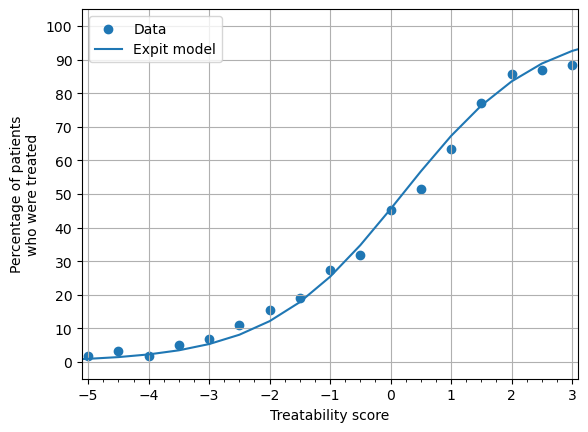

In [117]:
fig, ax = plt.subplots()

# Treatability score that gives 50% on the y-axis:
x_50perc = 0.2  # eyeballed
slope = 0.9  # eyeballed
# base_probability = 

# Define y-coordinates for a model line.
y_model = calculate_model_treatment_probability(hist_bins_mean, x_50perc, slope)
# Data:
ax.scatter(hist_bins_mean, perc_thrombolysed, label='Data')
# Model:
ax.plot(hist_bins_mean, y_model, label='Expit model')

# Graph setup:
ax.set_xlim(-5.1, 3.1)
ax.set_xticks(np.arange(-5.0, 3.0, 0.25), minor=True)
ax.set_yticks(np.arange(0.0, 100.1, 10))
ax.grid()

ax.set_xlabel('Treatability score')
ax.set_ylabel('Percentage of patients\nwho were treated')
ax.legend()

plt.show()

View data points from the chart:

In [101]:
pd.DataFrame([hist_bins_mean, perc_thrombolysed]).T

,0,1
0,-18.5,NaN
1,-18.0,0.000000
2,-17.5,0.000000
3,-17.0,0.000000
4,-16.5,NaN
5,-16.0,0.000000
6,-15.5,0.000000
7,-15.0,0.000000
8,-14.5,0.000000
9,-14.0,0.000000


## Convert scores to chance of being picked by np.choice

Use the model to convert each patient's treatability score into a probability of treatment:

In [102]:
all_model_treatability = calculate_model_treatment_probability(
    df_all_patient_shap_values['treatability_score'], x_50perc, slope)

Place this new data into the existing SHAP value data frame:

In [103]:
df_all_patient_shap_values['treatability_percentage_(model)'] = all_model_treatability

In [104]:
df_all_patient_shap_values.head(5).T

,0,1,2,3,4
stroke_severity,0.475304,-1.625403,0.844426,0.736321,0.914569
prior_disability,0.363717,-0.601054,0.363717,-0.026161,-0.601054
age,0.095047,-0.455455,0.095047,-0.455455,0.059954
infarction,0.341060,0.341060,0.341060,0.341060,-9.228256
onset_to_arrival_time,-0.205125,-0.409409,-0.205125,0.197819,-0.205125
...,...,...,...,...,...
team_117,0.002385,0.002385,-0.688748,0.002385,0.002385
team_118,-0.005982,-0.005982,-0.005982,-0.005982,-0.005982
team_119,0.000004,0.000004,0.000004,0.000004,0.000004
treatability_score,0.203616,-1.403822,1.578817,-1.382666,-8.433247


Take the first 1000 patients in the list.

In [105]:
n_subset = 1000

In [106]:
df_treatability = pd.DataFrame()
df_treatability['treatability_percentage_(model)'] = df_all_patient_shap_values['treatability_percentage_(model)'][:n_subset]

Normalise and divide by sum to get a series of values that add to one:

In [107]:
# Rename the array for easier reading:
modelled_treatability_percs = df_treatability['treatability_percentage_(model)']

# Normalise:
modelled_treatability_norm = (
    (modelled_treatability_percs - modelled_treatability_percs.min()) / 
    (modelled_treatability_percs.max() - modelled_treatability_percs.min())
    )

# Divide by sum:
modelled_treatability_relative_chance = (
    modelled_treatability_norm / modelled_treatability_norm.sum())

# Store in dataframe:
df_treatability['relative_chance'] = modelled_treatability_relative_chance

Also rank the patients in order of likeliness of being treated:

In [108]:
df_treatability = df_treatability.sort_values('treatability_percentage_(model)', ascending=False)

df_treatability['rank'] = np.arange(len(df_treatability))

View the dataframe:

In [109]:
df_treatability

,treatability_percentage_(model),relative_chance,rank
448,93.604423,2.683058e-03,0
192,93.496389,2.679962e-03,1
147,93.474447,2.679333e-03,2
528,93.416662,2.677676e-03,3
700,93.174031,2.670721e-03,4
...,...,...,...
537,0.000277,5.864130e-09,995
53,0.000228,4.466191e-09,996
729,0.000168,2.744756e-09,997
921,0.000131,1.685272e-09,998


A minor limitation of this method is that the final patient in the list has a 0% chance of being picked.

## Run trials of selecting patients for treatment

Run several trials of picking out 100 patients (10%) and see how this compares with their treatability score.

In [110]:
n_picked = 100
n_trials = 10

We'll select patients using their index values from the dataframe:

In [111]:
inds = modelled_treatability_relative_chance.index.values

The following cell runs the trials. The method is:

1. Use `np.choice` to select patients. The values selected are the index values of the DataFrame. The probability of being selected is not the same for all patients, but instead we weight the likeliness of being selected using the `relative_chance` calculated earlier.
2. Create boolean array to keep track of whether patients were picked.
3. Plot histograms of the picked patients' treatability percentages and their ranks in the ordered list of likeliness of being picked.

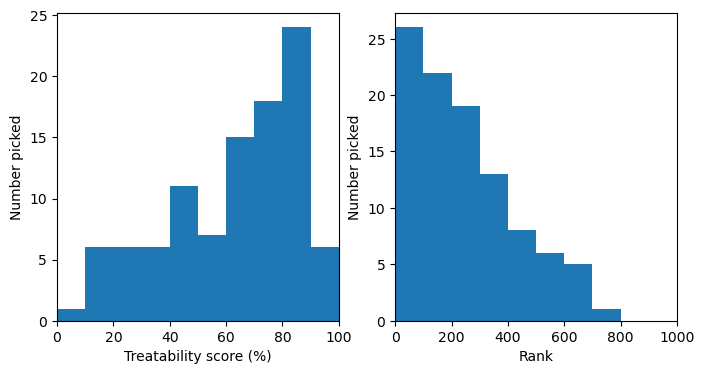

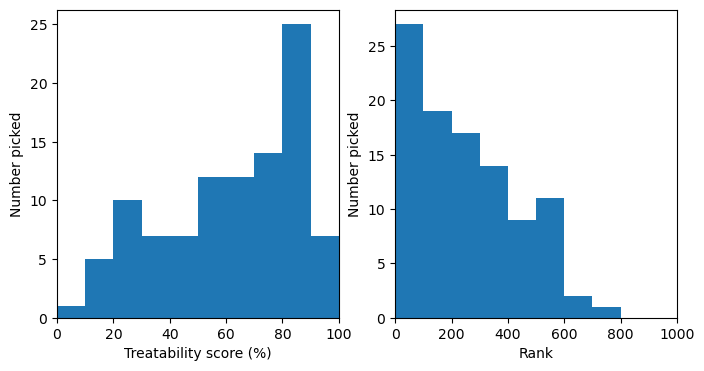

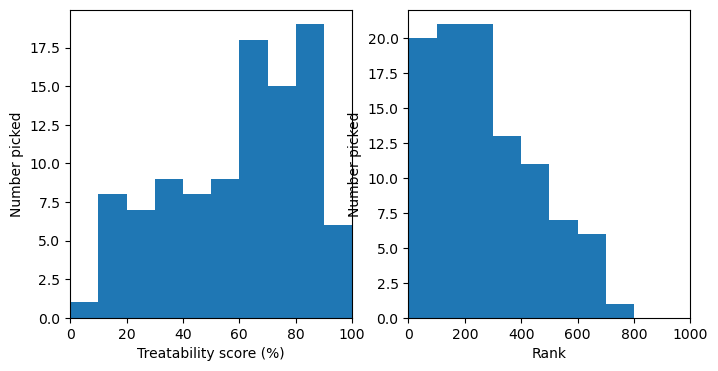

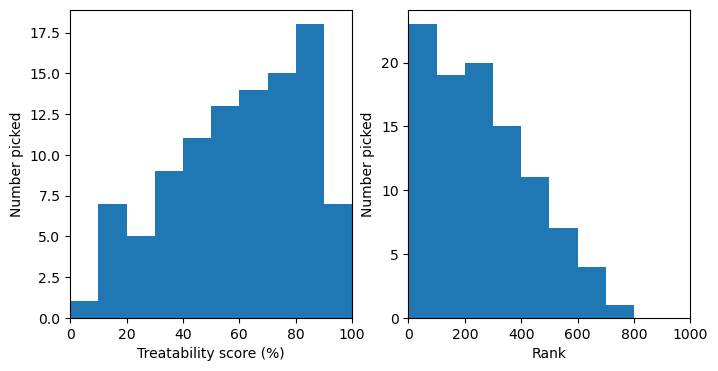

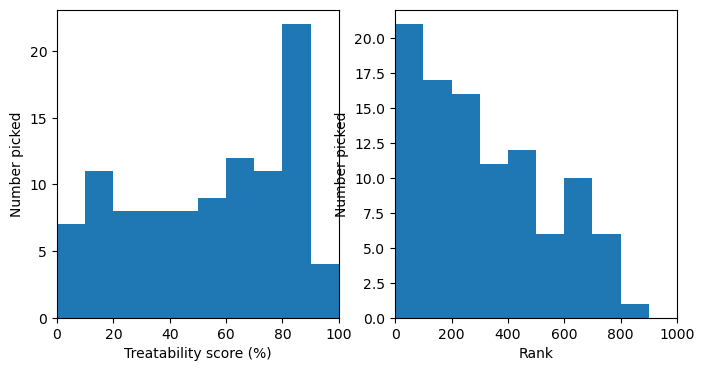

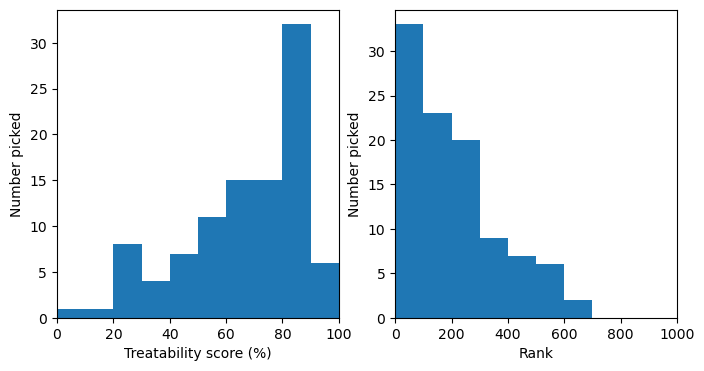

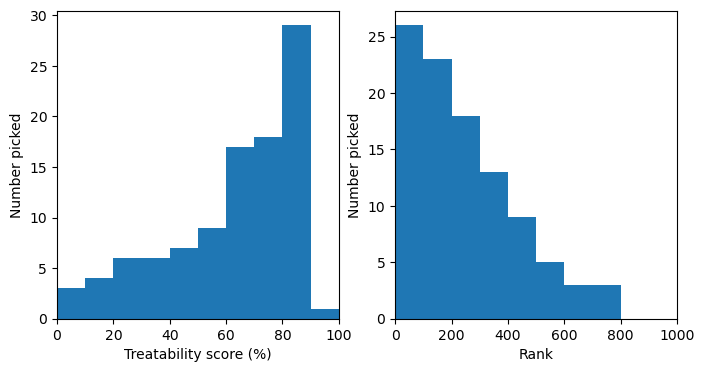

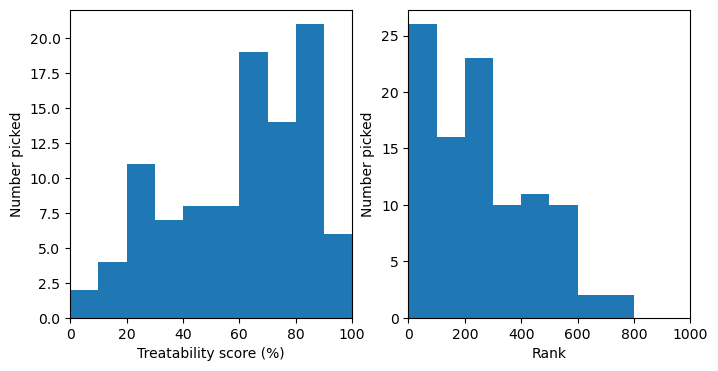

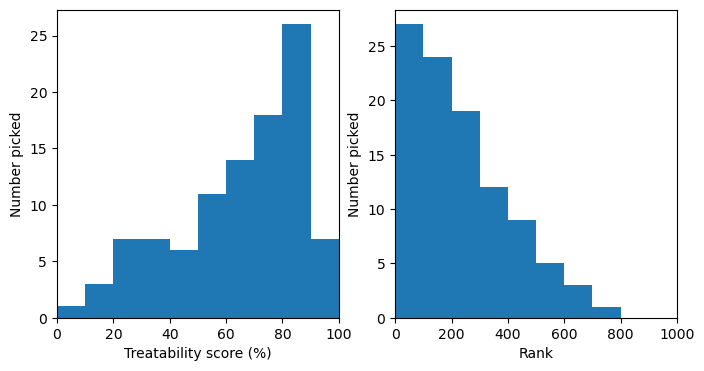

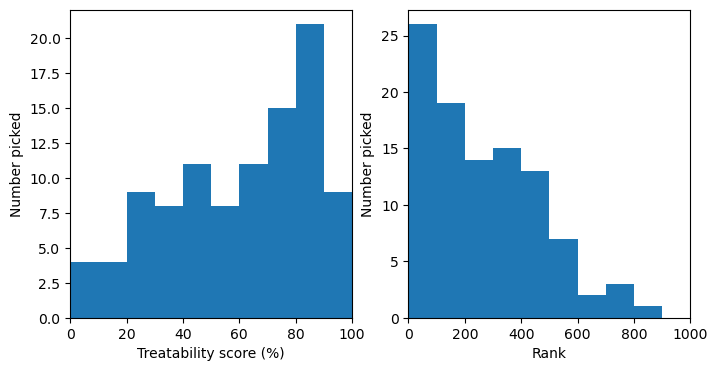

In [112]:
np.random.seed(42)

for t in range(n_trials):
    # Find indices of the selected patients.
    picked_patients = np.random.choice(
        inds, size=n_picked, replace=False, p=df_treatability['relative_chance'])

    # Create boolean array to track whether patients were picked.
    picked_bool = np.full(inds.shape, 0)
    picked_bool[picked_patients] = 1

    # Create bins to place the picked patients' values into
    # so that the histgorams are consistent across trials.
    treatability_hist_bins = np.arange(0.0, 100.1, 10)
    rank_hist_bins = np.arange(0, n_subset, 0.1*n_subset)

    # Plot the results.
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].hist(
        df_treatability['treatability_percentage_(model)'][picked_bool == 1],
        bins=treatability_hist_bins
        )
    axs[1].hist(df_treatability['rank'][picked_bool == 1], 
                bins=rank_hist_bins)

    axs[0].set_xlabel('Treatability score (%)')
    axs[0].set_ylabel('Number picked')
    axs[1].set_xlabel('Rank')
    axs[1].set_ylabel('Number picked')

    axs[0].set_xlim(0, 100)
    axs[1].set_xlim(0, 1000)
    plt.show()
    plt.close()

Most of the patients picked have higher treatability scores and so lower ranks in the list. However, the spread of patients is greater than only picking the top 100 most treatable would have been.